In [ ]:
pip install torch torchvision torchaudio torchtext pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchtext to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.2
    Uninstalling torch-2.2.2:
      Successfully uninstalled torch-2.2.2
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.17.2
    Uninstalling torchtext-0.17.2:
      Successfully uninstalled torchtext-0.17.2


In [ ]:
!pip install torch --upgrade
!pip install torchtext --upgrade

  Using cached torch-2.2.2-cp310-cp310-manylinux1_x86_64.whl (755.5 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1
    Uninstalling torch-2.2.1:
      Successfully uninstalled torch-2.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.
torchvision 0.17.1+cu121 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.
  Using cached torchtext-0.17.2-cp310-cp310-manylinux1_x86_64.whl (2.0 MB)
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.17.1
    Uninstalling torchtext-0.17.1:
      Successfully uninstalled torchtext-0.17.1


In [ ]:
import pandas as pd
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn

# Data loading

In [ ]:
from google.colab import files
import pandas as pd
data_to_load = files.upload()
import io

df = pd.read_excel('labeled_dataset.xlsx')
df.head()

Saving labeled_dataset.xlsx to labeled_dataset.xlsx


/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Unnamed: 0,sentence,news_link,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,article,biased_words4
0,0,YouTube is making clear there will be no “birt...,https://eu.usatoday.com/story/tech/2020/02/03/...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,YouTube says no ‘deepfakes’ or ‘birther’ video...,"['belated', 'birtherism']"
1,1,The increasingly bitter dispute between Americ...,https://www.nbcnews.com/news/sports/women-s-te...,msnbc,sport,left,1,1,Non-biased,Entirely factual,"FRISCO, Texas — The increasingly bitter disput...",['bitter']
2,2,So while there may be a humanitarian crisis dr...,https://www.alternet.org/2019/01/here-are-5-of...,alternet,immigration,left,1,1,Biased,Expresses writer’s opinion,Speaking to the country for the first time fro...,['crisis']
3,3,A professor who teaches climate change classes...,https://www.breitbart.com/politics/2019/05/09/...,breitbart,environment,right,1,1,Non-biased,No agreement,A professor who teaches climate change classes...,['legitimate']
4,4,"Looking around the United States, there is nev...",https://thefederalist.com/2020/03/11/woman-who...,federalist,abortion,right,1,1,Biased,Somewhat factual but also opinionated,The left has a thing for taking babies hostage...,"['killing', 'never', 'developing', 'humans', '..."


In [ ]:
# Deleting rows where 'Label_bias' is 'No agreement'
df = df.loc[df['Label_bias'] != 'No agreement']

print(df)

      Unnamed: 0                                           sentence  \
0              0  YouTube is making clear there will be no “birt...   
1              1  The increasingly bitter dispute between Americ...   
2              2  So while there may be a humanitarian crisis dr...   
3              3  A professor who teaches climate change classes...   
4              4  Looking around the United States, there is nev...   
...          ...                                                ...   
1695        1695  In every case legislators are being swarmed by...   
1696        1696  Polls show the transgender ideology is deeply ...   
1697        1697  Democrats and Republicans stood and applauded ...   
1698        1698  As a self-described Democratic socialist, Sen....   
1699        1699  During the segment, Colbert also bemoaned the ...   

                                              news_link      outlet  \
0     https://eu.usatoday.com/story/tech/2020/02/03/...   usa-today   
1    

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

texts = df['sentence'].tolist()
labels = label_encoder.fit_transform(df['Label_bias'].tolist())

texts_train, texts_test, labels_train, labels_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42)

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(texts_train), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

def text_pipeline(x):
    return vocab(tokenizer(x))

def label_pipeline(x):
    return int(x)

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [text_pipeline(text) for text in texts]
        self.labels = labels

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

    def __len__(self):
        return len(self.labels)

from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    text_list, label_list = [], []
    for (_text, _label) in batch:
        text_list.append(torch.tensor(_text, dtype=torch.int64))
        label_list.append(torch.tensor(_label, dtype=torch.int64))
    text_list = pad_sequence(text_list, batch_first=True)
    label_list = torch.stack(label_list)
    return text_list, label_list

train_dataset = TextDataset(texts_train, labels_train)
test_dataset = TextDataset(texts_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_batch)



# Model Building

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, (hidden, _) = self.lstm(embedded)
        hidden = hidden.squeeze(0)
        out = self.fc(hidden)
        return out

vocab_size = len(vocab)
embed_dim = 128
hidden_dim = 256
output_dim = len(set(labels))


model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, output_dim)


In [ ]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(3):
    for texts, labels in train_loader:
        optimizer.zero_grad()
        output = model(texts)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 0.808283805847168
Epoch 2, Loss: 0.5071524977684021
Epoch 3, Loss: 0.8046836853027344


# Evalation of the model

In [ ]:
def calculate_accuracy(preds, y):
    probs = torch.softmax(preds, dim=1)

    predictions = torch.argmax(probs, dim=1)

    correct = (predictions == y).float()
    acc = correct.sum() / len(correct)
    return acc


In [ ]:

model.eval()

total_accuracy = 0
total_count = 0

with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model(texts)
        # Calculate accuracy and update total accuracy
        accuracy = calculate_accuracy(outputs, labels)
        total_accuracy += accuracy.item()
        total_count += 1

# Calculate the average accuracy across all batches
average_accuracy = total_accuracy / total_count
print(f'Average Test Accuracy: {average_accuracy:.4f}')


Average Test Accuracy: 0.6670


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np

model.eval()

true_labels_list = []
pred_labels_list = []

with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model(texts)
        _, predicted_labels = torch.max(outputs, 1)

        true_labels_list.extend(labels.cpu().numpy())
        pred_labels_list.extend(predicted_labels.cpu().numpy())


In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(true_labels_list, pred_labels_list)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels_list, pred_labels_list, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.6656
Precision: 0.4466
Recall: 0.6656
F1 Score: 0.5345


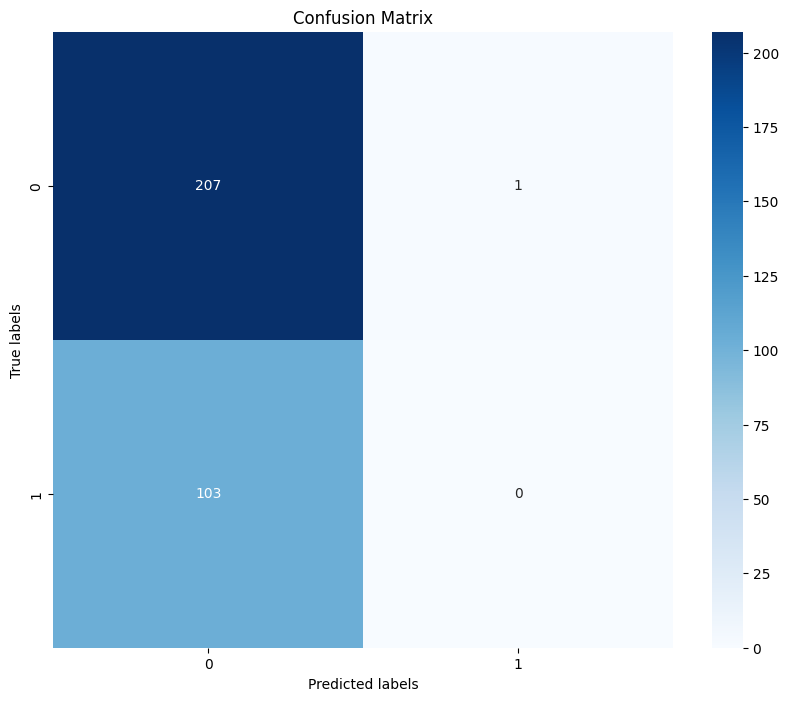

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels_list, pred_labels_list)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
